# moco (momentum contrast) - simplified cpu implementation

this notebook implements a simplified version of moco for self-supervised learning on cifar-10.

**paper**: [momentum contrast for unsupervised visual representation learning (cvpr 2020)](https://arxiv.org/abs/1911.05722)

**original code**: https://github.com/facebookresearch/moco

## 1. setup and imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import copy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# set device
device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cpu


## 2. data augmentation

moco uses two different augmented views of the same image as positive pairs.

In [2]:
class TwoCropsTransform:
    """Create two crops of the same image"""
    def __init__(self, base_transform):
        self.base_transform = base_transform
    
    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]

# augmentation for cifar-10 (32x32 images)
augmentation = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# test set transform (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

## 3. load cifar-10 dataset

In [3]:
# training dataset with two augmentations
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=TwoCropsTransform(augmentation)
)

# test dataset for evaluation
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

# dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')

100%|█████████████████████████████████████████████████| 170M/170M [00:22<00:00, 7.47MB/s]


Training samples: 50000
Test samples: 10000


## 4. moco model implementation

key components:
- **query encoder**: trainable encoder
- **momentum encoder**: slowly updated copy of query encoder
- **queue**: stores previous key embeddings as negative samples
- **contrastive loss**: infonce loss

In [4]:
class MoCo(nn.Module):
    def __init__(self, base_encoder, dim=128, K=1024, m=0.999, T=0.07):
        """
        Args:
            base_encoder: backbone network (e.g., ResNet-18)
            dim: feature dimension (default: 128)
            K: queue size (default: 1024)
            m: momentum for updating key encoder (default: 0.999)
            T: temperature parameter (default: 0.07)
        """
        super(MoCo, self).__init__()
        
        self.K = K
        self.m = m
        self.T = T
        
        # create query encoder
        self.encoder_q = base_encoder(num_classes=dim)
        
        # create momentum encoder
        self.encoder_k = base_encoder(num_classes=dim)
        
        # initialize momentum encoder with query encoder weights
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False  # no gradient for momentum encoder
        
        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = F.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))
    
    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """Momentum update of the key encoder"""
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1.0 - self.m)
    
    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        """Update queue: enqueue current keys, dequeue oldest"""
        batch_size = keys.shape[0]
        
        ptr = int(self.queue_ptr)
        
        # replace the keys at ptr (dequeue and enqueue)
        if ptr + batch_size <= self.K:
            self.queue[:, ptr:ptr + batch_size] = keys.T
        else:
            # wrap around
            remaining = self.K - ptr
            self.queue[:, ptr:] = keys[:remaining].T
            self.queue[:, :batch_size - remaining] = keys[remaining:].T
        
        ptr = (ptr + batch_size) % self.K  # move pointer
        self.queue_ptr[0] = ptr
    
    def forward(self, im_q, im_k):
        """
        Input:
            im_q: a batch of query images
            im_k: a batch of key images
        Output:
            logits, targets
        """
        # compute query features
        q = self.encoder_q(im_q)  # nxc
        q = F.normalize(q, dim=1)
        
        # compute key features (no gradient)
        with torch.no_grad():
            self._momentum_update_key_encoder()
            k = self.encoder_k(im_k)  # nxc
            k = F.normalize(k, dim=1)
        
        # compute logits
        # positive logits: nx1
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        # negative logits: nxk
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])
        
        # logits: nx(1+k)
        logits = torch.cat([l_pos, l_neg], dim=1)
        
        # apply temperature
        logits /= self.T
        
        # labels: positives are the 0-th
        labels = torch.zeros(logits.shape[0], dtype=torch.long, device=logits.device)
        
        # dequeue and enqueue
        self._dequeue_and_enqueue(k)
        
        return logits, labels

## 5. create resnet-18 encoder for cifar-10

In [5]:
def get_resnet18_cifar(num_classes=128):
    """ResNet-18 adapted for CIFAR-10 (32x32 images)"""
    model = models.resnet18(pretrained=False)
    
    # modify first conv layer for 32x32 images
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()  # remove maxpool for small images
    
    # modify final layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

## 6. initialize model and optimizer

In [6]:
# hyperparameters
dim = 128  # feature dimension
K = 1024  # queue size
m = 0.999  # momentum
T = 0.07  # temperature
lr = 0.03  # learning rate
epochs = 10  # number of epochs

# create model
model = MoCo(
    base_encoder=get_resnet18_cifar,
    dim=dim,
    K=K,
    m=m,
    T=T
).to(device)

# optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

# loss function
criterion = nn.CrossEntropyLoss()

print(f'Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

/home/rifatxia/Desktop/TensorstoreWork/tensorstore/llama-work/llama-venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rifatxia/Desktop/TensorstoreWork/tensorstore/llama-work/llama-venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model parameters: 11,234,496


## 7. training loop

In [7]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for images, _ in pbar:
        # images is a list [im_q, im_k]
        im_q = images[0].to(device)
        im_k = images[1].to(device)
        
        # forward pass
        logits, labels = model(im_q, im_k)
        loss = criterion(logits, labels)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # statistics
        total_loss += loss.item()
        _, predicted = logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
    
    return total_loss / len(loader), 100. * correct / total

# training
train_losses = []
train_accs = []

print('Starting MoCo pre-training...')
for epoch in range(epochs):
    print(f'\nEpoch {epoch+1}/{epochs}')
    loss, acc = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(loss)
    train_accs.append(acc)
    print(f'Loss: {loss:.4f}, Acc: {acc:.2f}%')

print('\nPre-training completed!')

Starting MoCo pre-training...

Epoch 1/10


Training: 100%|█████████████| 1563/1563 [23:05<00:00,  1.13it/s, loss=4.8265, acc=13.21%]


Loss: 5.1421, Acc: 13.21%

Epoch 2/10


Training: 100%|█████████████| 1563/1563 [22:21<00:00,  1.17it/s, loss=3.7010, acc=21.06%]


Loss: 4.4418, Acc: 21.06%

Epoch 3/10


Training: 100%|█████████████| 1563/1563 [20:49<00:00,  1.25it/s, loss=3.3300, acc=28.63%]


Loss: 3.8231, Acc: 28.63%

Epoch 4/10


Training: 100%|█████████████| 1563/1563 [20:46<00:00,  1.25it/s, loss=3.0897, acc=37.37%]


Loss: 3.2999, Acc: 37.37%

Epoch 5/10


Training: 100%|█████████████| 1563/1563 [21:15<00:00,  1.23it/s, loss=2.9650, acc=44.18%]


Loss: 2.8979, Acc: 44.18%

Epoch 6/10


Training: 100%|█████████████| 1563/1563 [20:49<00:00,  1.25it/s, loss=2.3557, acc=49.76%]


Loss: 2.5878, Acc: 49.76%

Epoch 7/10


Training: 100%|█████████████| 1563/1563 [20:49<00:00,  1.25it/s, loss=2.0306, acc=55.47%]


Loss: 2.3165, Acc: 55.47%

Epoch 8/10


Training: 100%|█████████████| 1563/1563 [21:35<00:00,  1.21it/s, loss=1.9750, acc=59.61%]


Loss: 2.1119, Acc: 59.61%

Epoch 9/10


Training: 100%|█████████████| 1563/1563 [23:01<00:00,  1.13it/s, loss=2.1196, acc=64.03%]


Loss: 1.9215, Acc: 64.03%

Epoch 10/10


Training: 100%|█████████████| 1563/1563 [20:11<00:00,  1.29it/s, loss=1.4548, acc=67.03%]

Loss: 1.7723, Acc: 67.03%

Pre-training completed!


## 8. plot training progress

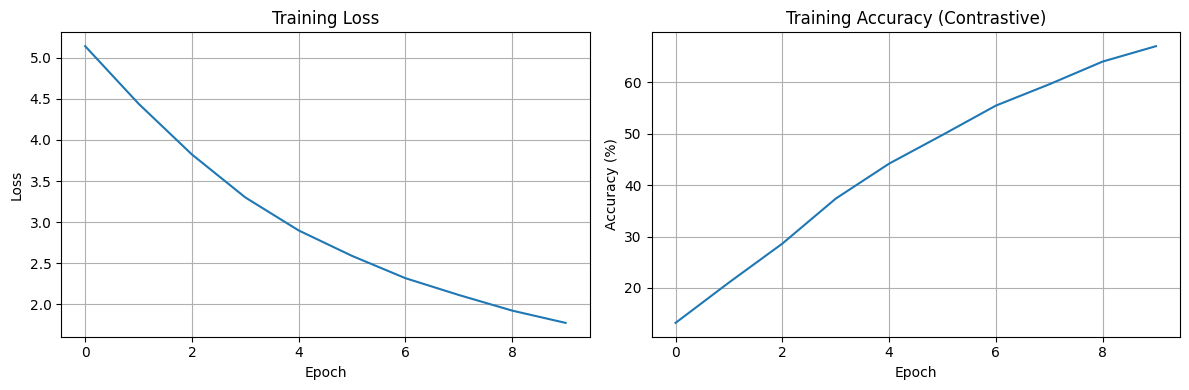

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

ax2.plot(train_accs)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training Accuracy (Contrastive)')
ax2.grid(True)

plt.tight_layout()
plt.show()

## 9. linear evaluation

evaluate the learned representations by training a linear classifier on top of the frozen encoder.

In [9]:
# create linear classifier
class LinearClassifier(nn.Module):
    def __init__(self, encoder, num_classes=10):
        super(LinearClassifier, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(128, num_classes)
        
        # freeze encoder
        for param in self.encoder.parameters():
            param.requires_grad = False
    
    def forward(self, x):
        with torch.no_grad():
            features = self.encoder(x)
        return self.fc(features)

# create classifier
classifier = LinearClassifier(model.encoder_q).to(device)

# new optimizer for linear layer only
optimizer_linear = optim.SGD(classifier.fc.parameters(), lr=30.0, momentum=0.9, weight_decay=0)
criterion_linear = nn.CrossEntropyLoss()

# load training data without augmentation for linear eval
train_dataset_linear = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=False,
    transform=test_transform
)
train_loader_linear = DataLoader(train_dataset_linear, batch_size=batch_size, shuffle=True, num_workers=2)

In [10]:
def train_linear(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc='Training Linear'):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

def test_linear(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

# train linear classifier
print('\nLinear Evaluation...')
linear_epochs = 20
best_acc = 0

for epoch in range(linear_epochs):
    print(f'\nEpoch {epoch+1}/{linear_epochs}')
    train_loss, train_acc = train_linear(classifier, train_loader_linear, optimizer_linear, criterion_linear, device)
    test_loss, test_acc = test_linear(classifier, test_loader, criterion_linear, device)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    
    if test_acc > best_acc:
        best_acc = test_acc

print(f'\nBest Test Accuracy: {best_acc:.2f}%')


Linear Evaluation...

Epoch 1/20


Testing: 100%|█████████████████████████████████████████| 313/313 [00:51<00:00,  6.09it/s]


Train Loss: 2638.9827, Train Acc: 39.82%
Test Loss: 2688.0220, Test Acc: 41.64%

Epoch 2/20


Testing: 100%|█████████████████████████████████████████| 313/313 [00:52<00:00,  5.99it/s]


Train Loss: 2587.6411, Train Acc: 41.06%
Test Loss: 2230.0624, Test Acc: 43.06%

Epoch 3/20


Testing: 100%|█████████████████████████████████████████| 313/313 [00:52<00:00,  5.99it/s]


Train Loss: 2609.3771, Train Acc: 41.58%
Test Loss: 2675.9563, Test Acc: 43.06%

Epoch 4/20


Testing: 100%|█████████████████████████████████████████| 313/313 [00:51<00:00,  6.12it/s]


Train Loss: 2592.9615, Train Acc: 41.91%
Test Loss: 2610.0625, Test Acc: 44.11%

Epoch 5/20


Testing: 100%|█████████████████████████████████████████| 313/313 [00:52<00:00,  5.97it/s]


Train Loss: 2539.7424, Train Acc: 42.10%
Test Loss: 2550.1285, Test Acc: 43.37%

Epoch 6/20


Testing: 100%|█████████████████████████████████████████| 313/313 [00:53<00:00,  5.86it/s]


Train Loss: 2557.1225, Train Acc: 42.31%
Test Loss: 2789.3816, Test Acc: 41.15%

Epoch 7/20


Testing: 100%|█████████████████████████████████████████| 313/313 [00:51<00:00,  6.13it/s]


Train Loss: 2528.7564, Train Acc: 42.99%
Test Loss: 2495.4272, Test Acc: 40.00%

Epoch 8/20


Testing: 100%|█████████████████████████████████████████| 313/313 [00:50<00:00,  6.17it/s]


Train Loss: 2521.2562, Train Acc: 42.73%
Test Loss: 2321.4603, Test Acc: 44.23%

Epoch 9/20


Testing: 100%|█████████████████████████████████████████| 313/313 [00:51<00:00,  6.10it/s]


Train Loss: 2520.3953, Train Acc: 42.88%
Test Loss: 2477.4120, Test Acc: 45.04%

Epoch 10/20


Testing: 100%|█████████████████████████████████████████| 313/313 [00:52<00:00,  6.00it/s]


Train Loss: 2555.1482, Train Acc: 42.87%
Test Loss: 2483.7867, Test Acc: 47.06%

Epoch 11/20


Testing: 100%|█████████████████████████████████████████| 313/313 [00:51<00:00,  6.13it/s]


Train Loss: 2509.6515, Train Acc: 43.30%
Test Loss: 2815.0235, Test Acc: 43.85%

Epoch 12/20


Testing: 100%|█████████████████████████████████████████| 313/313 [00:51<00:00,  6.12it/s]


Train Loss: 2476.1844, Train Acc: 43.52%
Test Loss: 2232.0125, Test Acc: 46.86%

Epoch 13/20


Testing: 100%|█████████████████████████████████████████| 313/313 [00:52<00:00,  5.96it/s]


Train Loss: 2469.7588, Train Acc: 43.47%
Test Loss: 2511.2248, Test Acc: 46.25%

Epoch 14/20


Testing: 100%|█████████████████████████████████████████| 313/313 [00:52<00:00,  5.95it/s]


Train Loss: 2468.4768, Train Acc: 43.38%
Test Loss: 2584.0371, Test Acc: 44.42%

Epoch 15/20


Testing: 100%|█████████████████████████████████████████| 313/313 [00:52<00:00,  6.01it/s]


Train Loss: 2533.8335, Train Acc: 43.64%
Test Loss: 2251.3136, Test Acc: 47.53%

Epoch 16/20


Testing: 100%|█████████████████████████████████████████| 313/313 [00:53<00:00,  5.86it/s]


Train Loss: 2492.9233, Train Acc: 43.78%
Test Loss: 2416.5975, Test Acc: 45.50%

Epoch 17/20


Testing: 100%|█████████████████████████████████████████| 313/313 [00:52<00:00,  5.99it/s]


Train Loss: 2460.5127, Train Acc: 43.99%
Test Loss: 2429.1222, Test Acc: 43.46%

Epoch 18/20


Testing: 100%|█████████████████████████████████████████| 313/313 [00:51<00:00,  6.05it/s]


Train Loss: 2508.1067, Train Acc: 43.89%
Test Loss: 2251.1087, Test Acc: 47.04%

Epoch 19/20


Testing: 100%|█████████████████████████████████████████| 313/313 [00:51<00:00,  6.13it/s]


Train Loss: 2455.1374, Train Acc: 44.13%
Test Loss: 2108.1396, Test Acc: 47.62%

Epoch 20/20


Testing: 100%|█████████████████████████████████████████| 313/313 [00:51<00:00,  6.11it/s]

Train Loss: 2453.8563, Train Acc: 43.94%
Test Loss: 2524.3555, Test Acc: 45.28%

Best Test Accuracy: 47.62%


## 10. save model

In [11]:
# save the pre-trained encoder
torch.save({
    'encoder': model.encoder_q.state_dict(),
    'classifier': classifier.fc.state_dict(),
    'best_acc': best_acc,
}, 'moco_cifar10.pth')

print('Model saved to moco_cifar10.pth')

Model saved to moco_cifar10.pth


## summary

this notebook demonstrates a simplified cpu-friendly implementation of moco:

1. **pre-training**: learned visual representations using contrastive learning
2. **linear evaluation**: evaluated learned features by training a linear classifier

### key simplifications:
- small backbone (resnet-18)
- small queue (k=1024)
- small dataset (cifar-10)
- cpu training
- fewer epochs

### expected results:
- with proper training (more epochs), moco can achieve 70-80% accuracy on cifar-10
- this simplified version should achieve 50-60% accuracy

### next steps:
1. train for more epochs (100+)
2. increase queue size (k=4096)
3. use gpu for faster training
4. try moco v2 improvements (stronger augmentation, mlp projection head)